# Subsampling Example - using bootstrap methods
#### by Elizabeth Barnes

An illustration of using Bootstrapping.

#### The problem

This example is based on the "Resampling: bootstrap" example in Chapter 1 of the lecture notes, and is actually an example taken from my research life where I got to be a co-author on the paper for doing this analysis! The idea is as follows...

You believe that aerosols grow the most when you have high geopotential heights nearby. You composite the 500 geopotential height on the 20 August days when you have aerosol formation and growth over a site in Egbert, Canada, and you find that the average geopotential on these days is 5900 m. The long-term mean at this station is 5886 m, so the heights appear higher during aerosol growth. Are these results significant? Or is this just random chance?

#### The approach

The first thing to notice is that you may have no idea what the distribution of daily 500 hPa geopotential heights even looks like. Now, you do have years and years of data, so you can plot it (and we will), but I doesn't look particularly normal. Next, you might say "that's okay. I'll just use the Central Limit Theorem", but with only N = 20, you may not have enough points to invoke that yet. So...what do you do? 

The idea is that while you do not know the underlying distribution (and thus, cannot use Monte Carlo where you have to know the underlying distribution in order to code it up), you do have _a lot_ of data, so why not use the data instead?

Here's what we will do in the steps below: Run 2,500 experiments, within each experiment, randomly grab 20 days from the historical geopotential height data, and take the mean of the 20 days. After 2,500 iterations, you will have a distribution of the N = 20 sample means under the null hypothesis of random chance. Now, you can look at this distribution and determine the 95% confidence bounds on the N = 20 sample means - if the observed value of 5900 m is outside of this range, you have reason to believe it may be more than random chance.

In [23]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

#.............................................
# IMPORT STATEMENTS
#.............................................
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.io as sio
import importlib

import general_functions as gf
importlib.reload(gf)
gf.add_parent_dir_to_path()

from lib import class_general_functions as cgf
importlib.reload(cgf)

#.............................................
# PLOTTING COMMANDS
#.............................................
gf.cc()
plt.ioff()

We will start from loading our (ahem) Matlab data.

In [24]:
DATA = sio.loadmat('data/subsampling_example_Z500_August.mat')
X = DATA['X'][:,0]
LAT = DATA['LAT'][0][0]
LONG = DATA['LONG'][0][0]

Next, as all good scientists do, we plot our data (histogram of 500 hPa heights for all August days) to get a feeling for what it looks like.

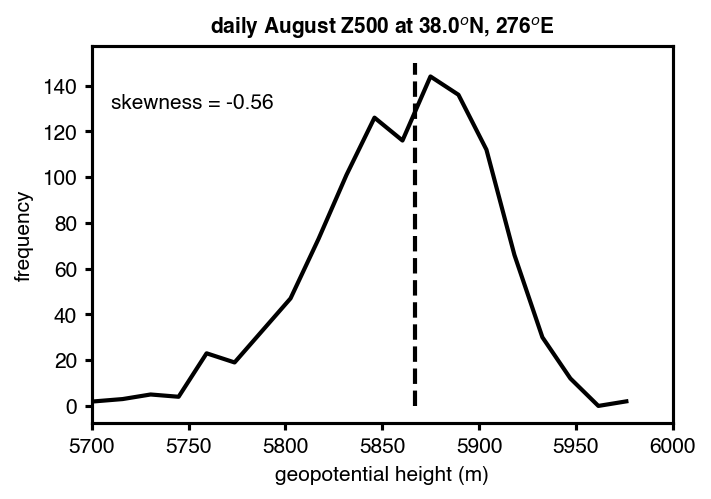

In [25]:
cgf.cfig(1)
h, bins = np.histogram(X,20)
plt.plot(bins[:-1],h, color = 'black')

plt.xlabel('geopotential height (m)')
plt.ylabel('frequency')

plt.plot([np.mean(X), np.mean(X)],[0., 150],'--', color = 'black')

plt.title('daily August Z500 at ' + str(np.round(LAT)) + '$^o$N, ' + str(round(LONG)) + '$^o$E')

Z = (X-np.mean(X))/np.std(X)
plt.text(5710, 130, 'skewness = ' + str(gf.round_to_nearest(stats.skew(Z[:]), 0.01))) 

plt.xlim(5700, 6000)

plt.show()

The black line shows the histogram of the August days, and the dashed black line is the mean. As you can see, the data is skewed and not particularly normal looking - so, we probably shouldn't use the Central Limit Theorem here.

Next, we define the variable "sample_length" so that we can change it later. For this problem, our initial size of our sample is N=20.

In [26]:
sample_length = 20

This is where the magic happens. We are now going to _randomly_ grab 2500 different samples of size N = sample_length. That is, we are going to pretend we know nothing about aerosol growth and just grab random combinations of samples. We do this 2500 times, but it could be 5000, or 10,000. Etc. However many zeros you wish :)

After randomly grabbing each sample we will calculate the mean geopotential height over the sample, save it in an array called "P", and then rinse and repeat.

In [27]:
#note, I recently learned about P = np.random.choice() - so also an option for writing this code

P = np.empty(2500)
for j, val in enumerate(P):
    ir = stats.randint.rvs(0,len(X)-1,size = sample_length)
    P[j] = np.nanmean(X[ir])

Our hard work is done. Now we just plot the results. That is, we plot the histogram of the means of our random samples of size N = 20. 

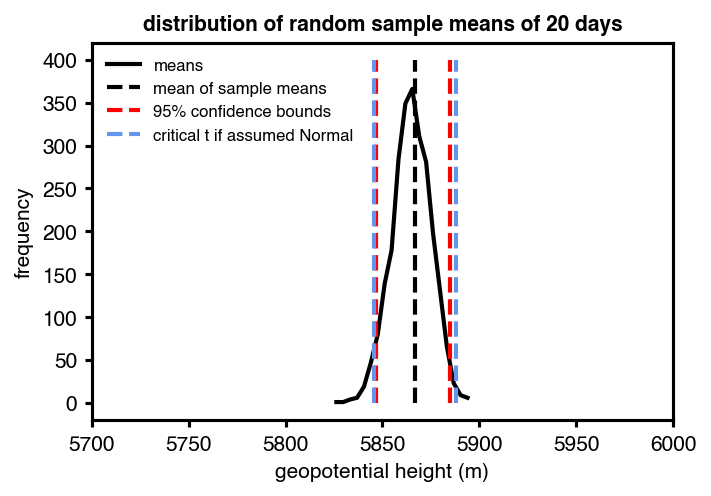

In [28]:
mp = 0.

fig, ax = cgf.cfig(2)
h, bins = np.histogram(P-mp,20)
plt.plot(bins[:-1],h, color = 'black', label = 'means')
plt.plot((np.mean(X), np.mean(X)),(0., 400),'--', color = 'black', label = 'mean of sample means');

a1 = np.percentile(P-mp,2.5)
a2 = np.percentile(P-mp,100.-2.5)

plt.plot((a1,a1),(0,400),'--',color = 'red', linewidth = 2, label = '95% confidence bounds')
plt.plot((a2,a2),(0,400),'--',color = 'red', linewidth = 2)

t_inc = (stats.t.ppf(0.975, sample_length - 1))*np.std(X)/np.sqrt(sample_length-1)

plt.plot(np.ones((2,))*(np.mean(X)-t_inc), (0,400), '--',color = 'cornflowerblue', label = 'critical t if assumed Normal')
plt.plot(np.ones((2,))*(np.mean(X)+t_inc), (0,400), '--',color = 'cornflowerblue')

plt.xlabel('geopotential height (m)')
plt.ylabel('frequency')

plt.legend(fontsize = 8, frameon = False)

plt.title('distribution of random sample means of ' + str(sample_length) + ' days')
plt.xlim(5700, 6000)

fig
#plt.show()

The black line above shows us the range of random sampled means of length N = 20 we can get when the data is totally random. The dashed black line shows the mean of these means of random samples. 

The red lines denote the actual 95% bounds of the data - that is, the true bounds where 95% of the means fall within the range. The dashed blue lines are the 95% bounds _if we had assumed the daily data was normal_. See how they are different?

Also notice that the x-axis scale on this plot is the same as the plot above. Notice how the distribution of sample means is narrower than the full daily distribution? This is because when you average things together you get a better estimate of the true mean (a narrower distribution).

 Let's zoom in a bit more.

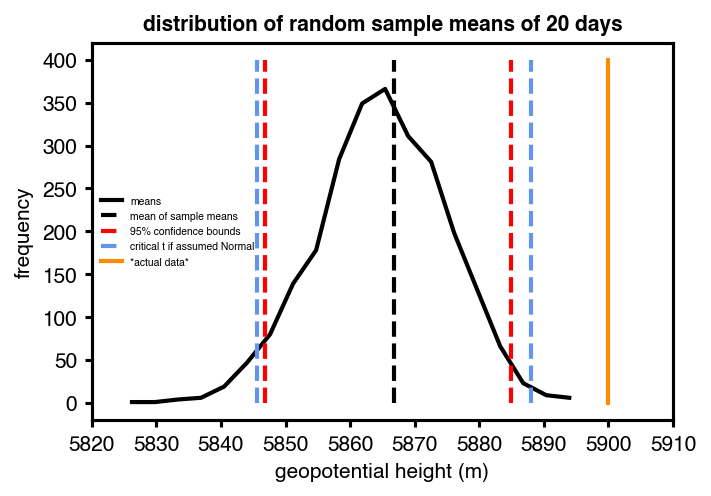

In [29]:
plt.xlim(5820,5910)
plt.plot((5900,5900),(0,400),'-',color='darkorange', label='*actual data*')
plt.legend(fontsize = 5, frameon = False)
fig

It is now much more clear that if we had used the t-test rather than a bootstrapping approach we would have had a _wider_ 95% bounds. Either way, we now answer our question of whether 5900 m is "special" compared to what we could have gotten from random chance. The answer is yes! Note how 5900 m falls outside of the 95% bounds (red lines), and thus, we can reject the null hypothesis that there is nothing special about geopotential heights during aersol growth. Said another way (in sciency english), it appears the geopotential heights might actually be larger during aersol growth!